In [1]:
from Bio import Entrez
from dotenv import load_dotenv
import os
load_dotenv()

Entrez.email = os.getenv("ENTREZ_EMAIL")
Entrez.api_key = os.getenv("ENTREZ_API_KEY")  



# API

In [2]:
import json
import re
import requests
import time
import random
import logging
from typing import Optional
api_key = os.getenv("ENTREZ_API_KEY")   # Store your key securely
print(api_key)
base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=gene&term=LMP10"
params = {
    "api_key": api_key,
    "retmode": "json", 
}
response = requests.get(base_url, params=params)

if response.status_code == 200:
    data = response.json()
    # Process your data
    print(data)
else:
    print(f"Error: {response.status_code} - {response.text}")

b33cc4163334cc7e1c39200bb7cb96a0f808
{'header': {'type': 'esearch', 'version': '0.3'}, 'esearchresult': {'count': '3', 'retmax': '3', 'retstart': '0', 'idlist': ['19171', '5699', '8138'], 'translationset': [], 'translationstack': [{'term': 'LMP10[All Fields]', 'field': 'All Fields', 'count': '3', 'explode': 'N'}, 'GROUP'], 'querytranslation': 'LMP10[All Fields]'}}


In [3]:
# def call_api(url: str, params: dict | None = None, timeout: int = 60, max_retries: int = 3) -> bytes:
#     """
#     Perform an HTTP GET request to the given URL (with optional params) and return raw bytes.
#     Retries with exponential back-off (up to 3 times) on rate limit or server errors.
#     """
#     base_delay = 1  # seconds
#     for attempt in range(max_retries):
#         try:
#             if attempt > 0:
#                 delay = base_delay * (2 ** (attempt - 1)) + random.uniform(0, 0.5)
#                 logging.warning(f"API request failed (attempt {attempt+1}/{max_retries}): Retrying in {delay:.1f}s...")
#                 time.sleep(delay)
#             response = requests.get(url, params=params, timeout=timeout)
#             response.raise_for_status()
#             return response.content
#         except requests.exceptions.RequestException as e:
#             status = getattr(e.response, "status_code", None)
#             if status in [429, 500, 502, 503, 504] or isinstance(e, requests.exceptions.Timeout):
#                 continue  # retry
#             else:
#                 logging.error(f"API request failed: {e}")
#                 raise
#     logging.error(f"API request failed after {max_retries} retries: {url} params={params}")
#     raise RuntimeError(f"API request failed after {max_retries} retries: {url} params={params}")

In [ ]:
import json
import re
import requests
import time
import random
import logging
from typing import Optional

# Basic setup
logging.basicConfig(level=logging.INFO)
load_dotenv()


NCBI_API_KEY = os.getenv("ENTREZ_API_KEY")  
load_dotenv()

NCBI_EUTILS_BASE = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
NCBI_BLAST_BASE = "https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi"

# Rate-limiting handling
def call_ncbi_api(url: str, params: dict | None = None, timeout: int = 60, max_retries: int = 3) -> bytes:
    base_delay = 1  # seconds
    for attempt in range(max_retries):
        try:
            if attempt > 0:
                delay = base_delay * (2 ** (attempt - 1)) + random.uniform(0, 0.5)
                logging.warning(f"Retry {attempt}/{max_retries}: Waiting {delay:.1f}s before retrying...")
                time.sleep(delay)
            response = requests.get(url, params=params, timeout=timeout)
            response.raise_for_status()
            return response.content
        except requests.exceptions.RequestException as e:
            status = getattr(e.response, "status_code", None)
            if status in [429, 500, 502, 503, 504] or isinstance(e, requests.exceptions.Timeout):
                continue
            else:
                raise
    raise RuntimeError(f"Failed after {max_retries} retries for URL: {url} params={params}")

def extract_rid(response_bytes: bytes) -> Optional[str]:
    if not response_bytes:
        return None
    match = re.search(r'RID\s*=\s*([A-Z0-9]+)', response_bytes.decode('utf-8', errors='ignore'))
    return match.group(1).strip() if match else None

def load_questions(json_path: str) -> dict:
    with open(json_path, "r") as f:
        return json.load(f)

def handle_question(question: str) -> str:
    if "official gene symbol of" in question:
        term = question.split("of")[-1].strip("? ")
        return gene_alias_lookup(term)
    elif "genes related to" in question:
        disease = question.split("to")[-1].strip("? ")
        return gene_disease_lookup(disease)
    elif "chromosome is" in question and "located" in question:
        gene = question.split("is")[1].split("gene")[0].strip()
        return gene_location_lookup(gene)
    elif "Align the DNA sequence to the human genome" in question:
        seq = question.split(":")[-1].strip()
        return parse_genomic_coordinates(seq)
    elif "organism does the DNA sequence come from" in question:
        seq = question.split(":")[-1].strip()
        return identify_organism(seq)
    elif "Convert" in question and "to official gene symbol" in question:
        ensg = question.split("Convert")[-1].split("to")[0].strip()
        return ensg_to_symbol(ensg)
    elif "Is" in question and "a protein-coding gene?" in question:
        gene = question.split("Is")[-1].split("a")[0].strip()
        return is_protein_coding(gene)
    elif "gene is SNP" in question:
        rsid = re.findall(r'rs\d+', question)[0]
        return snp_to_gene(rsid)
    elif "chromosome does SNP" in question:
        rsid = re.findall(r'rs\d+', question)[0]
        return snp_location(rsid)
    else:
        return "Unknown question type."


def gene_alias_lookup(term: str) -> str:
    search_url = NCBI_EUTILS_BASE + "esearch.fcgi"
    summary_url = NCBI_EUTILS_BASE + "esummary.fcgi"

    search_params = {
        "db": "gene",
        "term": term,
        "retmax": 3,
        "retmode": "json",
        "api_key": NCBI_API_KEY,
    }

    result = call_ncbi_api(search_url, search_params)
    ids = json.loads(result)["esearchresult"]["idlist"]
    if not ids:
        return "NA"

    summary_params = {
        "db": "gene",
        "id": ",".join(ids),
        "retmode": "json",
        "api_key": NCBI_API_KEY,
    }

    summary_result = call_ncbi_api(summary_url, summary_params)
    summary_data = json.loads(summary_result)
    for uid in ids:
        if uid in summary_data["result"]:
            return summary_data["result"][uid].get("name", "NA")
    return "NA"


def gene_disease_lookup(disease: str) -> str:
    """
    Uses esearch to find genes associated with a given disease name.
    """
    search_url = NCBI_EUTILS_BASE + "esearch.fcgi"
    params = {
        "db": "gene",
        "term": f"{disease}[disease]",
        "retmax": 10,
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }

    result = call_ncbi_api(search_url, params)
    ids = json.loads(result)["esearchresult"]["idlist"]
    if not ids:
        return "NA"
    
    summary_url = NCBI_EUTILS_BASE + "esummary.fcgi"
    summary_params = {
        "db": "gene",
        "id": ",".join(ids),
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }
    summary_result = call_ncbi_api(summary_url, summary_params)
    summary_data = json.loads(summary_result)
    names = [summary_data["result"][uid]["name"] for uid in ids if uid in summary_data["result"]]
    return ", ".join(names) if names else "NA"

def gene_location_lookup(gene: str) -> str:
    """
    Use esearch and esummary to find the chromosome location of a gene.
    """
    search_url = NCBI_EUTILS_BASE + "esearch.fcgi"
    summary_url = NCBI_EUTILS_BASE + "esummary.fcgi"

    params = {
        "db": "gene",
        "term": f"{gene}[gene]",
        "retmax": 1,
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }

    result = call_ncbi_api(search_url, params)
    ids = json.loads(result)["esearchresult"]["idlist"]
    if not ids:
        return "NA"

    summary_params = {
        "db": "gene",
        "id": ids[0],
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }
    summary_result = call_ncbi_api(summary_url, summary_params)
    data = json.loads(summary_result)
    chromosome = data["result"][ids[0]].get("chromosome", "NA")
    return f"chr{chromosome}" if chromosome != "NA" else "NA"

def ensg_to_symbol(ensg: str) -> str:
    """
    Converts an Ensembl gene ID to the official gene symbol.
    """
    search_url = NCBI_EUTILS_BASE + "esearch.fcgi"
    summary_url = NCBI_EUTILS_BASE + "esummary.fcgi"

    search_params = {
        "db": "gene",
        "term": f"{ensg}[Source ID]",
        "retmax": 1,
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }

    result = call_ncbi_api(search_url, search_params)
    ids = json.loads(result)["esearchresult"]["idlist"]
    if not ids:
        return "NA"

    summary_params = {
        "db": "gene",
        "id": ids[0],
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }
    summary_result = call_ncbi_api(summary_url, summary_params)
    data = json.loads(summary_result)
    return data["result"][ids[0]].get("name", "NA")

def snp_to_gene(rsid: str) -> str:
    """
    Retrieves gene associated with a given SNP ID using dbSNP.
    """
    rsid = rsid.replace("rs","")
    summary_url = NCBI_EUTILS_BASE + "esummary.fcgi"
    params = {
        "db": "snp",
        "id": rsid,
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }
    result = call_ncbi_api(summary_url, params)
    data = json.loads(result)
    print(data)
    # Attempt to extract gene name from snp summary
    docsum = data["result"].get(rsid)
    if not docsum:
        return "NA"
    gene_info = docsum.get("genes", {})
    if isinstance(gene_info, dict):
        return gene_info.get("name", "NA")
    elif isinstance(gene_info, list):
        return ", ".join([g.get("name", "NA") for g in gene_info])
    return "NA"

def snp_location(rsid: str) -> str:
    """
    Retrieves the chromosome location of a SNP.
    """
    rsid = rsid.replace("rs", "")
    summary_url = NCBI_EUTILS_BASE + "esummary.fcgi"
    params = {
        "db": "snp",
        "id": rsid,
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }
    result = call_ncbi_api(summary_url, params)
    data = json.loads(result)
    print(data)
    docsum = data["result"].get(rsid)
    if not docsum:
        return "NA"
    chr_num = docsum.get("chr", "NA")
    return f"chr{chr_num}" if chr_num != "NA" else "NA"


import time
import re
import requests

def submit_blast_query(sequence: str) -> str:
    url = "https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi"
    params = {
        "CMD": "Put",
        "PROGRAM": "blastn",
        "DATABASE": "nt",
        "QUERY": sequence,
        "MEGABLAST": "on",
        "FORMAT_TYPE": "Text",
        "HITLIST_SIZE": 5
    }
    response = requests.post(url, data=params)
    match = re.search(r"RID\s*=\s*([A-Z0-9]+)", response.text)
    return match.group(1).strip() if match else None

def retrieve_blast_result(rid: str, wait_seconds: int = 15) -> str:
    url = "https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi"
    params = {"CMD": "Get", "RID": rid, "FORMAT_TYPE": "Text"}
    time.sleep(wait_seconds)
    for _ in range(5):
        resp = requests.get(url, params=params)
        if "Status=WAITING" in resp.text:
            time.sleep(5)
        elif "Status=FAILED" in resp.text:
            raise RuntimeError("BLAST job failed.")
        elif "No hits found" in resp.text:
            return "No hits found"
        else:
            return resp.text
    raise TimeoutError("Timed out waiting for BLAST result.")

# def submit_blast_query(sequence: str) -> str:
#     url = "https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi"
#     params = {
#         "CMD": "Put",
#         "PROGRAM": "blastn",
#         "DATABASE": "nt",
#         "QUERY": sequence,
#         "MEGABLAST": "on",
#         "FORMAT_TYPE": "Text",
#         "HITLIST_SIZE": 5
#     }
#     response = requests.post(url, data=params)
#     match = re.search(r"RID\s*=\s*([A-Z0-9]+)", response.text)
#     return match.group(1).strip() if match else None

# def retrieve_blast_result(rid: str, wait_seconds: int = 15) -> str:
#     url = "https://blast.ncbi.nlm.nih.gov/blast/Blast.cgi"
#     params = {"CMD": "Get", "RID": rid, "FORMAT_TYPE": "Text"}
#     time.sleep(wait_seconds)
#     for _ in range(5):
#         resp = requests.get(url, params=params)
#         if "Status=WAITING" in resp.text:
#             time.sleep(5)
#         elif "Status=FAILED" in resp.text:
#             raise RuntimeError("BLAST job failed.")
#         elif "No hits found" in resp.text:
#             return "No hits found"
#         else:
#             return resp.text
#     raise TimeoutError("Timed out waiting for BLAST result.")

def parse_genomic_coordinates(seq: str) -> str:
    # Look for line with chromosome and positions
    rid = submit_blast_query(seq)
    blast_output = retrieve_blast_result(rid)
    chr_line = re.search(r">.*chromosome\s+(\w+)[^\n]*\n", blast_output)
    start = re.search(r"Sbjct\s+(\d+)\s+\w+", blast_output)
    end = re.findall(r"Sbjct\s+(\d+)\s+\w+", blast_output)
    if chr_line and start and end:
        chr_num = chr_line.group(1)
        start_pos = start.group(1)
        end_pos = end[-1]  # last occurrence
        print("chr num:", chr_num)
        
        return f"chr{chr_num}:{start_pos}-{end_pos}"
    return "NA"

# def parse_genomic_coordinates(blast_output: str) -> str:
#     # Look for line with chromosome and positions
#     chr_line = re.search(r">.*chromosome\s+(\w+)[^\n]*\n", blast_output)
#     start = re.search(r"Sbjct\s+(\d+)\s+\w+", blast_output)
#     end = re.findall(r"Sbjct\s+(\d+)\s+\w+", blast_output)
#     if chr_line and start and end:
#         chr_num = chr_line.group(1)
#         start_pos = start.group(1)
#         end_pos = end[-1]  # last occurrence
#         return f"chr{chr_num}:{start_pos}-{end_pos}"
#     return "NA"

def extract_first_hit_line(blast_output: str) -> str:
    """
    Return the first hit line after 'Sequences producing significant alignments:'.
    """
    lines = blast_output.splitlines()
    for i, line in enumerate(lines):
        if "Sequences producing significant alignments:" in line:
            # Return the next non-empty line
            for next_line in lines[i + 1:]:
                if next_line.strip():  # skip empty lines
                    return next_line
            break
    return "NA"


def extract_first_hit_organism_from_hits_section(blast_output: str) -> str:
    """
    Extract the organism name from the first hit in the BLAST alignment section.
    """
    # Find the "Sequences producing significant alignments" section
    alignments_section = extract_first_hit_line(blast_output)
    print("match", alignments_section)
    # section = alignments_section.group(0)
    line = alignments_section.strip()
    
    # Skip the header line and get the first actual hit
    # for line in lines[1:]:
    #     line = line.strip()
    #     if not line:
    #         continue
        # Match organism name pattern in the hit line
    # organism_match = re.search(r'\b([A-Z][a-z]+ [a-z]+)\b', line)
    # print("organism:", organism_match)
    # if organism_match:
    #     sci_name = organism_match.group(1)
    #     # Map scientific to common names
    organism_map = {'Caenorhabditis elegans': 'worm',
            'Homo sapiens': 'human',
            'Danio rerio': 'zebrafish',
            'Mus musculus': 'mouse',
            'Saccharomyces cerevisiae': 'yeast',
            'Rattus norvegicus': 'rat',
            'Gallus gallus': 'chicken'}
    #     return organism_map.get(sci_name, sci_name)
    for sci_name, common_name in organism_map.items():
        if sci_name in line or common_name in line:
            print("common_name:", common_name)
            return common_name
    return "NA"



def identify_organism(sequence: str) -> str:
    """Full pipeline: submit → wait → retrieve → extract organism."""
    try:
    
        rid = submit_blast_query(sequence)
        print(f"RID: {rid}")
        result_text = retrieve_blast_result(rid)
    
        organism = extract_first_hit_organism_from_hits_section(result_text)
        return organism
    except Exception as e:
        return f"Error: {e}"




# def blast_align_human(seq: str) -> str:
#     """
#     Align DNA sequence to human genome using NCBI BLAST.
#     """
#     put_params = {
#         "CMD": "Put",
#         "PROGRAM": "blastn",
#         "DATABASE": "nt",
#         "MEGABLAST": "on",
#         "FORMAT_TYPE": "XML",
#         "QUERY": seq,
#         "HITLIST_SIZE": 1
#     }

#     response = call_ncbi_api(NCBI_BLAST_BASE, put_params)
#     rid = extract_rid(response)
#     if not rid:
#         return "NA"


#     for _ in range(10):
#         time.sleep(3)
#         check_params = {"CMD": "Get", "RID": rid, "FORMAT_TYPE": "Text"}
#         result = call_ncbi_api(NCBI_BLAST_BASE, check_params)
#         text = result.decode("utf-8")
#         if "No hits found" in text:
#             return "NA"
#         match = re.search(r"(?i)(chr[0-9XYM]+:\d+-\d+)", text)
#         if match:
#             return match.group(1)
#     return "NA"

# def blast_align_species(seq: str) -> str:
#     """
#     Determine the organism for a DNA sequence using NCBI BLAST.
#     """
#     put_params = {
#         "CMD": "Put",
#         "PROGRAM": "blastn",
#         "DATABASE": "nt",
#         "MEGABLAST": "on",
#         "FORMAT_TYPE": "XML",
#         "QUERY": seq,
#         "HITLIST_SIZE": 1
#     }

#     response = call_ncbi_api(NCBI_BLAST_BASE, put_params)
#     rid = extract_rid(response)
#     if not rid:
#         return "NA"

#     for _ in range(10):
#         time.sleep(3)
#         check_params = {"CMD": "Get", "RID": rid, "FORMAT_TYPE": "Text"}
#         result = call_ncbi_api(NCBI_BLAST_BASE, check_params)
#         text = result.decode("utf-8")
#         match = re.search(r">.+\[(.+?)\]", text)
#         if match:
#             return match.group(1).lower()
#     return "NA"

def is_protein_coding(gene: str) -> str:
    import xml.etree.ElementTree as ET

    search_url = NCBI_EUTILS_BASE + "esearch.fcgi"
    search_params = {
        "db": "gene",
        "term": f"{gene}[Symbol]",
        "retmode": "json",
        "retmax": 1,
        "api_key": NCBI_API_KEY
    }
    result = call_ncbi_api(search_url, search_params)

    ids = json.loads(result)["esearchresult"]["idlist"]
    if not ids:
        logging.warning(f"Gene not found: {gene}")
        return "NA"
    
    gene_id = ids[0]

 
    fetch_url = NCBI_EUTILS_BASE + "efetch.fcgi"
    fetch_params = {
        "db": "gene",
        "id": gene_id,
        "retmode": "xml",
        "api_key": NCBI_API_KEY
    }
    response = call_ncbi_api(fetch_url, fetch_params)

    root = ET.fromstring(response.decode("utf-8"))

    for gene_ref in root.iter("Gene-ref"):
        
        gene_type_elem = gene_ref.find("Gene-ref_desc")
        if gene_type_elem is not None and gene_type_elem.text:
            gene_type = gene_type_elem.text.strip()
            logging.info("Gene type (desc): %s", gene_type)
            if "non-protein" in gene_type:
                return "NA" 
            else: 
                return "TRUE"
        else:
            logging.info("Gene-ref_desc not found")
            return "NA"



In [7]:
import ast

def handle_question(question: str) -> str:
    if "official gene symbol of" in question:
        term = question.split("of")[-1].strip("? ")
        return gene_alias_lookup(term)
    elif "genes related to" in question:
        disease = question.split("to")[-1].strip("? ")
        return gene_disease_lookup(disease)
    elif "chromosome is" in question and "located" in question:
        gene = question.split("is")[1].split("gene")[0].strip()
        return gene_location_lookup(gene)
    elif "Align the DNA sequence to the human genome" in question:
        seq = question.split(":")[-1].strip()
        return parse_genomic_coordinates(seq)
    elif "organism does the DNA sequence come from" in question:
        seq = question.split(":")[-1].strip()
        return identify_organism(seq)
    elif "Convert" in question and "to official gene symbol" in question:
        ensg = question.split("Convert")[-1].split("to")[0].strip()
        return ensg_to_symbol(ensg)
    elif "Is" in question and "a protein-coding gene?" in question:
        gene = question.split("Is")[-1].split("a")[0].strip()
        return is_protein_coding(gene)
    elif "gene is SNP" in question:
        rsid = re.findall(r'rs\d+', question)[0]
        return snp_to_gene(rsid)
    elif "chromosome does SNP" in question:
        rsid = re.findall(r'rs\d+', question)[0]
        return snp_location(rsid)
    elif "aliases of the gene that contains this sequ" in question:
        seq = question.split(":")[-1].strip().strip(".")
        return identify_gene_alias_by_sequence(seq)

    elif "chromosome locations of the genes related to" in question:
        match = re.search(r"related to (.+?)(\.|$)", question)
        if match:
            disease = match.group(1).strip()
            return get_gene_locations_by_disease(disease)
        return "NA"
    elif "function of the gene associated with SNP" in question:
        rsid = re.findall(r'rs\d+', question)
        if rsid:
            return get_gene_function_from_snp(rsid[0])
        return "NA"

    else:
        return "Unknown question type."
    

def identify_gene_alias_by_sequence(seq: str) -> str:
    """BLAST DNA sequence and return gene aliases of the top hit if available."""
    try:
        rid = submit_blast_query(seq)
        result = retrieve_blast_result(rid)
        gene_match = re.search(r">.*? ([A-Z0-9]+)\.? ", result)
        if gene_match:
            gene_name = gene_match.group(1)
            return gene_alias_lookup(gene_name)
    except Exception as e:
        logging.warning(f"Failed to find alias by sequence: {e}")
    return "NA"

def get_gene_locations_by_disease(disease_name: str) -> list[str]:
    ids = gene_disease_lookup_ids(disease_name)
    if not ids:
        return ["NA"]

    summary_url = NCBI_EUTILS_BASE + "esummary.fcgi"
    params = {
        "db": "gene",
        "id": ",".join(ids),
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }
    result = call_ncbi_api(summary_url, params)
    data = json.loads(result)
    
    locations = []
    for uid in ids:
        chr_ = data["result"].get(uid, {}).get("chromosome")
        if chr_:
            locations.append(f"{chr_}")
    return locations if locations else ["NA"]

def gene_disease_lookup_ids(disease: str) -> list[str]:
    search_url = NCBI_EUTILS_BASE + "esearch.fcgi"
    params = {
        "db": "gene",
        "term": f"{disease}[disease]",
        "retmax": 10,
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }
    result = call_ncbi_api(search_url, params)
    return json.loads(result)["esearchresult"].get("idlist", [])

def get_gene_function_from_snp(rsid: str) -> str:
    rsid = rsid.replace("rs", "")
    link_url = NCBI_EUTILS_BASE + "elink.fcgi"
    params = {
        "dbfrom": "snp",
        "db": "gene",
        "id": rsid,
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }
    result = call_ncbi_api(link_url, params)
    data = json.loads(result)
    
    gene_ids = []
    try:
        linksets = data["linksets"][0]["linksetdbs"]
        for db in linksets:
            if db["dbto"] == "gene":
                gene_ids.extend(db["links"])
    except Exception:
        return "NA"

    if not gene_ids:
        return "NA"

    summary_url = NCBI_EUTILS_BASE + "esummary.fcgi"
    summary_params = {
        "db": "gene",
        "id": ",".join(gene_ids),
        "retmode": "json",
        "api_key": NCBI_API_KEY
    }
    summary_result = call_ncbi_api(summary_url, summary_params)
    summary_data = json.loads(summary_result)
    summaries = []
    for gid in gene_ids:
        info = summary_data["result"].get(gid, {}).get("summary")
        if info:
            summaries.append(info)

    return summaries[0] if summaries else "NA"


test_sequence = "GTAGATGGAACTGGTAGTCAGCTGGAGAGCAGCATGGAGGCGTCCTGGGGGAGCTTCAACGCTGAGCGGGGCTGGTATGTCTCTGTCCAGCAGCCTGAAGAAGCGGAGGCCGA"
print("Gene aliases by sequence:", identify_gene_alias_by_sequence(test_sequence))
test_snp = "rs900745020"
print("Gene function from SNP:", get_gene_function_from_snp(test_snp))
test_disease = "Gastrointestinal defects and immunodeficiency syndrome"
print("Gene locations by disease:", get_gene_locations_by_disease(test_disease))




Gene aliases by sequence: ACAT1
Gene function from SNP: The product of this gene belongs to the CRE (cAMP response element)-binding protein family. Members of this family contain zinc-finger and bZIP DNA-binding domains. The encoded protein specifically binds to CRE as a homodimer or a heterodimer with c-Jun or CRE-BP1, and functions as a CRE-dependent trans-activator. Alternatively spliced transcript variants encoding different isoforms have been identified. [provided by RefSeq, Jul 2008]
Gene locations by disease: ['NA']


In [ ]:
from pathlib import Path
from tqdm import tqdm
def process_json_questions(input_path: str, output_path: str) -> None:
    input_path = Path(input_path)
    output_path = Path(output_path)

    with input_path.open("r") as f:
        data = json.load(f)

    results = {}

    for task, qa_dict in data.items():
        results[task] = {}
        for question, true_answer in  tqdm(qa_dict.items()):
            try:
                predicted_answer = handle_question(question)
            except Exception as e:
                predicted_answer = f"Error: {str(e)}"
            results[task][question] = {
                "predicted": predicted_answer,
                "true": true_answer
            }

    with output_path.open("w") as f:
        json.dump(results, f, indent=2)


input_path = "/work/bioinformatics/s440708/MODULE_3_MATERIALS/data/genehop.json"
output_path = "/work/bioinformatics/s440708/MODULE_3_MATERIALS/outputs/genehop_entrez.json"
process_json_questions(input_path, output_path)

 88%|████████▊ | 44/50 [12:47<01:48, 18.02s/it]

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn.functional as F
import pandas as pd
tokenizer = AutoTokenizer.from_pretrained("FremyCompany/BioLORD-2023")
model = AutoModel.from_pretrained("FremyCompany/BioLORD-2023")


# with open(
#     os.path.join(
#         data_config["output_path"],
#         f"{data_config['dataset_name']}_{model_config['api']}_rawresults.csv",
#     ),
#     "r",
# ) as f:
#     pred_data = json.load(f)

with open("/work/bioinformatics/s440708/MODULE_3_MATERIALS/outputs/genehop_entrez.json", "r") as f:
    data = json.load(f)


# In[ ]:


# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("FremyCompany/BioLORD-2023")
model = AutoModel.from_pretrained("FremyCompany/BioLORD-2023")


# Helper function for mean pooling
def mean_pooling(
    model_output: torch.Tensor, attention_mask: torch.Tensor
) -> torch.Tensor:
    token_embeddings = model_output[0]
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )


results = []
gold_entries = []
for task_name, task_dict in gold_data.items():
    for question, answers in task_dict.items():
        gold_entries.append(
            {
                "task": task_name,
                "question": question.replace(
                    "Let's decompose the question to sub-questions \
                          and solve them step by step.",
                    "",
                ).strip(),
                "gold_answers": answers,
            }
        )

# Compute similarity
for task, questions in data.items():
    # question = pred_entry["question"].strip()
    # predicted_answer = pred_entry["answer"].strip()
    # task_name = pred_entry["task"]

    # match = gold_entries[i]
    # gold_answer = match["gold_answers"]
    for question, answers in questions.items():
        predicted_answer = answers['predicted']
        gold_answer = answers['true']
        if isinstance(gold_answer, list):
            gold_answer = " ".join(gold_answer)

        inputs = tokenizer(
            [predicted_answer, gold_answer],
            padding=True,
            truncation=True,
            return_tensors="pt",
        )
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = mean_pooling(outputs, inputs["attention_mask"])
            embeddings = F.normalize(embeddings, p=2, dim=1)
            cosine_sim = F.cosine_similarity(embeddings[0], embeddings[1], dim=0).item()
            print(cosine_sim)
            results.append(
                {
                    "task": task_name,
                    "question": question,
                    "predicted_answer": predicted_answer,
                    "gold_answer": gold_answer,
                    "cosine_similarity": cosine_sim,
                }
            )


df = pd.DataFrame(results)



print("cosine similarity", df["cosine_similarity"].mean())




df.to_csv("/work/bioinformatics/s440708/MODULE_3_MATERIALS/outputs/genehop_entrez_cosine_similarity.csv")



🔎 Overall score: 68.88%


🔎 Overall lev_distance: 833.33%

Task: Gene alias
  Accuracy: 70.00%
  Avg. Levenshtein distance: 1.72

Task: Gene disease association
  Accuracy: 63.65%
  Avg. Levenshtein distance: 31.88

Task: Gene location
  Accuracy: 56.30%
  Avg. Levenshtein distance: 1.94

Task: Human genome DNA aligment
  Accuracy: 40.00%
  Avg. Levenshtein distance: 13.82

Task: Multi-species DNA aligment
  Accuracy: 60.00%
  Avg. Levenshtein distance: 2.74

Task: Gene name conversion
  Accuracy: 100.00%
  Avg. Levenshtein distance: 0.00

Task: Protein-coding genes
  Accuracy: 30.00%
  Avg. Levenshtein distance: 22.90

Task: Gene SNP association
  Accuracy: 100.00%
  Avg. Levenshtein distance: 0.00

Task: SNP location
  Accuracy: 100.00%
  Avg. Levenshtein distance: 0.00



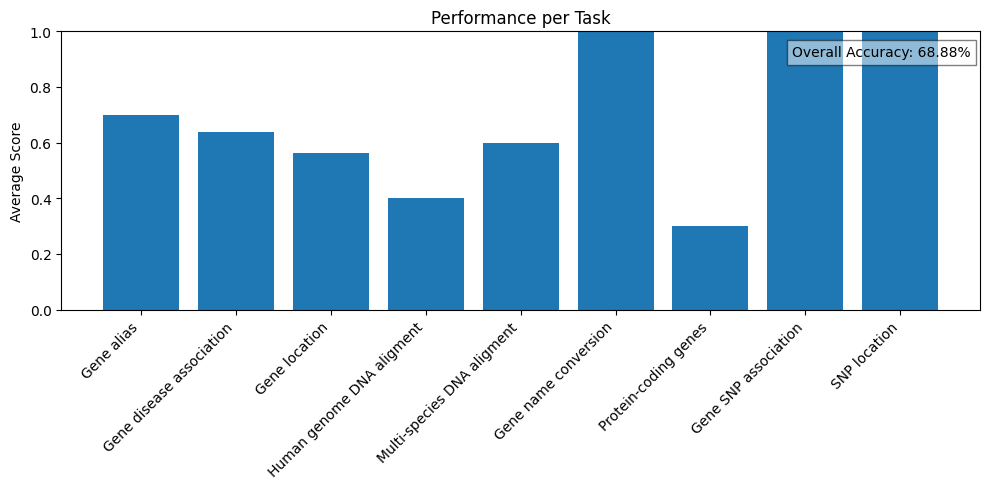

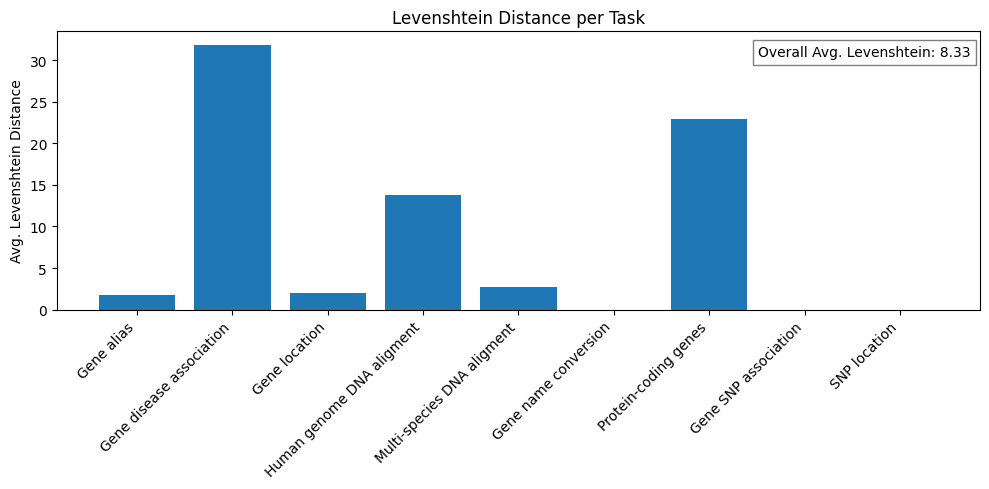

In [ ]:

from collections import defaultdict
from typing import Callable, Union, Dict, List, cast
import json
import matplotlib.pyplot as plt
import Levenshtein
def exact_match(pred: str, true: str) -> float:
    # if isinstance(pred, list):
    #     pred = [p.strip().lower() for p in pred]
    #     return float(true.strip().lower() in pred)
    # else:
    #     return float(pred.strip().lower() == true.strip().lower())
    if pred.strip().lower() == true.strip().lower():
        return 1.0
    else:
        return 0.0


def gene_disease_association(pred: list[str], true: list[str]) -> float:
    pred_set = set(map(str.lower, map(str.strip, pred)))
    true_set = set(map(str.lower, map(str.strip, true)))
    if not true_set:
        return 1.0 if not pred_set else 0.0
    return len(pred_set & true_set) / len(true_set)


def disease_gene_location(pred: list[str], true: list[str]) -> float:
    pred_set = set(map(str.lower, map(str.strip, pred)))
    true_set = set(map(str.lower, map(str.strip, true)))
    if not true_set:
        return 1.0 if not pred_set else 0.0
    return len(pred_set & true_set) / len(true_set)


def human_genome_dna_alignment(pred: str, true: str) -> float:
    pred = pred.strip().lower()
    true = true.strip().lower()
    if pred == true:
        return 1.0
    pred_chr = pred.split(":")[0]
    true_chr = true.split(":")[0]
    return 0.5 if pred_chr == true_chr else 0.0


MetricFunc = Callable[[Union[str, list[str]], Union[str, list[str]]], float]

metric_task_map: Dict[str, MetricFunc] = defaultdict(
    lambda: cast(MetricFunc, exact_match),
    {
        "Gene disease association": cast(MetricFunc, gene_disease_association),
        "Gene location": cast(MetricFunc, disease_gene_location),
        "Human genome DNA aligment": cast(MetricFunc, human_genome_dna_alignment),
    },
)


def evaluate_predictions_metric_based(data, metric_task_map):
    total_score = 0.0
    total_count = 0
    task_stats = defaultdict(lambda: {'score_sum': 0.0, 'count': 0, 'lev_sum': 0})
    total_lev_distance = 0
    
    for task, examples in data.items():
        metric = metric_task_map[task]
        for _, answers in examples.items():
            pred = answers["predicted"]
            true = answers["true"]

            # Convert strings like "['a', 'b']" to lists if needed
            if isinstance(pred, str) and pred.startswith("[") and pred.endswith("]"):
                pred = eval(pred)
            if isinstance(true, str) and true.startswith("[") and true.endswith("]"):
                true = eval(true)

            try:
                score = metric(pred, true)
            except Exception as e:
                print(f"Error in task {task}: {e}")
                score = 0.0


            lev = Levenshtein.distance(pred, true)
            total_lev_distance += lev
            task_stats[task]['lev_sum'] += lev
            
            total_score += score
            total_count += 1
            task_stats[task]['score_sum'] += score
            task_stats[task]['count'] += 1

    overall_score = total_score / total_count
    overall_lev = total_lev_distance / total_count
    print(f"\n🔎 Overall score: {overall_score:.2%}\n")
    print(f"\n🔎 Overall lev_distance: {overall_lev:.2%}\n")
    tasks = []
    accs = []
    lev_dists = []

    for task, stats in task_stats.items():
        acc = stats['score_sum'] / stats['count']
        avg_lev = stats['lev_sum'] / stats['count']
        print(f"Task: {task}")
        print(f"  Accuracy: {acc:.2%}")
        print(f"  Avg. Levenshtein distance: {avg_lev:.2f}\n")
        tasks.append(task)
        accs.append(acc)
        lev_dists.append(avg_lev)

    # Plot bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(tasks, accs)
    plt.ylabel('Average Score')
    plt.title('Performance per Task')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    plt.text(0.99, 0.95, f'Overall Accuracy: {overall_score:.2%}',
             transform=plt.gca().transAxes,
             ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.tight_layout()
    plt.show()

    # Plot Levenshtein distance per task
    plt.figure(figsize=(10, 5))
    plt.bar(tasks, lev_dists)
    plt.ylabel('Avg. Levenshtein Distance')
    plt.title('Levenshtein Distance per Task')
    plt.xticks(rotation=45, ha='right')
    plt.text(0.99, 0.95, f'Overall Avg. Levenshtein: {overall_lev:.2f}',
             transform=plt.gca().transAxes,
             ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.tight_layout()
    plt.show()

with open('/work/bioinformatics/s440708/MODULE_3_MATERIALS/outputs/geneturing_entrez.json') as f:
    data = json.load(f)

evaluate_predictions_metric_based(data, metric_task_map)